In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
# def addDramaInfo (drama_title) 
#     main_actor_only_json[drama_title]
    


In [8]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [9]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""

In [10]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
#         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

1910_EX_木22


In [11]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [12]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [13]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [14]:
df_actress_pivot

,橋本環奈,佐々木希,松雪泰子,深津絵里,上戸,樹木希林,柴崎コウ,高畑充希,菜々緒,小雪,吉高由里子,小泉今日子,山口智子,松,堀北真希,武井,観月ありさ,吉瀬美智子,戸田恵梨香,榮倉奈々,波瑠,桐谷美玲,黒木メイサ,宮崎あおい,松嶋菜々子,篠原涼子,上戸彩,永作博美,多部未華子,竹内結子,香里奈,石田ゆり子,有村架純,剛力彩芽,蒼井優,常盤貴子,武井咲,木村佳乃,薬師丸ひろ子,優香,江角マキコ,広瀬アリス,吉永小百合,米倉涼子,上野樹里,宮_あおい,新垣結衣,井上真央,芦田愛菜,天海祐希,土屋太鳳,杏,柴咲コウ,仲間由紀恵,藤原紀香,能年玲奈,松たか子,真矢みき,吉田羊,松下奈緒,木村文乃,石原さとみ,長澤まさみ,菅野美穂,広瀬すず,綾瀬はるか,深田恭子,北川景子,黒木瞳
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,11,NaN,15,NaN,29,NaN,25,NaN,NaN,NaN,23,NaN,3,21,4,NaN,NaN,8,NaN,NaN,NaN,NaN,26,24,NaN,NaN,NaN,12,NaN,NaN,22,19,NaN,10,9,28,NaN,1,NaN,NaN,7,2,27,NaN,16,18,NaN,NaN,NaN,NaN,17,5,NaN,6,20,NaN,14
2011,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,28,NaN,14,NaN,24,NaN,NaN,NaN,NaN,NaN,7,NaN,8,12,3,29,NaN,13,NaN,NaN,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,26,18,9,10,27,NaN,6,NaN,NaN,4,5,NaN,NaN,19,20,NaN,23,NaN,21,NaN,1,NaN,2,17,15,30
2012,NaN,NaN,30,11,6,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,24,5,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,1,15,NaN,NaN,NaN,8,25,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,14,17,NaN,29,26,NaN,NaN,7,13,20,3,NaN,NaN,10,4,NaN,NaN,NaN,27,NaN,NaN,NaN,23,12,9,NaN,2,21,18,NaN
2013,NaN,NaN,NaN,16,NaN,18,NaN,NaN,NaN,NaN,28,21,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,5,10,4,NaN,NaN,25,NaN,NaN,NaN,30,NaN,23,26,NaN,29,12,15,NaN,27,11,NaN,NaN,9,20,NaN,3,NaN,NaN,8,7,NaN,NaN,NaN,22,NaN,NaN,NaN,19,17,6,NaN,1,13,14,NaN
2014,NaN,NaN,NaN,27,NaN,24,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,2,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,14,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,28,16,20,NaN,19,13,NaN,30,5,17,NaN,9,NaN,15,7,10,NaN,25,23,NaN,NaN,29,NaN,8,22,6,NaN,1,18,4,NaN
2015,NaN,21,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,26,24,NaN,NaN,2,NaN,NaN,27,NaN,NaN,NaN,29,NaN,NaN,14,13,10,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,19,NaN,NaN,25,9,30,NaN,5,20,NaN,8,NaN,7,6,3,NaN,17,11,NaN,NaN,NaN,NaN,12,22,15,NaN,1,18,4,NaN
2016,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,27,NaN,NaN,19,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,21,14,12,NaN,NaN,26,NaN,NaN,3,NaN,NaN,NaN,23,NaN,NaN,24,NaN,NaN,25,20,NaN,29,4,30,NaN,7,NaN,11,13,9,NaN,NaN,17,NaN,16,NaN,NaN,5,22,18,15,1,8,2,NaN
2017,NaN,30,NaN,25,NaN,NaN,13,NaN,NaN,NaN,21,27,NaN,NaN,15,NaN,NaN,NaN,NaN,26,NaN,9,NaN,NaN,22,10,12,NaN,24,29,NaN,20,6,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,1,28,NaN,8,19,14,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,16,17,11,2,5,4,NaN


In [15]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [16]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,橋本環奈,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
1,佐々木希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,30,12,16
2,松雪泰子,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,深津絵里,NaN,NaN,13,11,11,16,27,28,28,25,27,NaN
4,上戸,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,樹木希林,NaN,NaN,NaN,NaN,NaN,18,24,NaN,NaN,NaN,NaN,NaN
6,柴崎コウ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN
7,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20
8,菜々緒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN
9,小雪,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [19]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [20]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [21]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [22]:
# df_merged[["main_actor1","2017","2016","2014"]]
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new4years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2016-01-01", '%Y-%m-%d')]

In [26]:
df_new4years

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,NTV,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,2016,4,1604_NTV_土21,福士蒼汰,土屋太鳳,田中メカ「お迎えです。」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24
192,CX,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,2016,4,1604_CX_土23,ユースケ・サンタマリア,優香,雫井脩介「火の粉」,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,14,12,16,19,24,NaN,NaN,NaN
193,CX,日21,OUR HOUSE,4.8,5.0,4.0,3.8,5.4,6.1,4.2,3.9,3.3,-,-,-,-,-,-,4.51,3-5-0,2016-04-01,2016,4,1604_CX_日21,芦田愛菜,シャーロット・ケイト・フォックス,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,芦田愛菜,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,28,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,TBS,日21,99.9,15.5,19.1,16.2,16.3,18.9,13.3,17.7,18.6,16.5,19.1,-,-,-,-,-,17.15,6-3-0,2016-04-01,2016,4,1604_TBS_日21,松本潤,香川照之,,松本潤,NaN,NaN,10,6,8,6,4,8,10,20,23,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,香川照之,NaN,NaN,NaN,31,NaN,15,15,11,NaN,NaN,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [27]:
df_new4years["main_actor1_rank"] = np.nan
df_new4years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new4years)):
    #print(df_new4years.iloc[i])
#     print(df_new4years.iloc[i]["start_at"])
    prev_year = df_new4years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new4years.loc[:,df_new4years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new4years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new4years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
df_new4years["main_actor1_rank"]

0      NaN
1      1.0
2      NaN
3      NaN
4      NaN
      ... 
191    NaN
192    NaN
193    NaN
194    8.0
195    NaN
Name: main_actor1_rank, Length: 196, dtype: float64

In [30]:
df_new4years["main_actor2_rank"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
191     NaN
192    19.0
193     NaN
194    11.0
195     NaN
Name: main_actor2_rank, Length: 196, dtype: float64

In [31]:
df_episode = df_new4years.loc[:, df_new4years.columns.str.contains("Epi")]

In [32]:
df_new4years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
#         print(str(df_new4years[col].iloc[i] )+ "__"+str(vr_sum) +"_"+str(epi_i) + "index"+str(i))
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new4years["average_calc"].iloc[i] = vr_sum/epi_i
            break
#            df_new4years["average_calc"].iloc[i] = vr_sum/i
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new4years["average_calc"].iloc[i] = vr_sum / 15
        
        #df_new4years.iloc[i]
    

## CM数も特徴量に

In [34]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [35]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [36]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [37]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [38]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [39]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [40]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

In [41]:
### 表示の確認
# for t_n in df_cm_pivot["actor_actress"].values:
#     if t_n in rank_arr: print(t_n)
    

# 特徴量エンジニアリング

### 俳優ランクを人気ポイントに

In [42]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_rank"].apply(lambda x : 40 - x )

In [43]:
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_rank"].apply(lambda x : 40 - x )

In [44]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_pt"].fillna(0)
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_pt"].fillna(0)

In [45]:
df_new4years["has_original_work"] = df_new4years["original_work"].apply(lambda x : "" if x =="" else True ) 

### 俳優

### one hotエンコーディング

In [46]:
df_new4years = pd.get_dummies(df_new4years, columns=["TV_station", "start_at_month", "start_at_year","has_original_work"] )

### モデル作成

In [47]:
lm = LinearRegression()

In [48]:
y = df_new4years["average"]

In [49]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,1,0
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,1.0,NaN,9.340000,39.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
4,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木22,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390000,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,1604_NTV_土21,福士蒼汰,土屋太鳳,田中メカ「お迎えです。」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24,NaN,NaN,7.922222,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
192,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,1604_CX_土23,ユースケ・サンタマリア,優香,雫井脩介「火の粉」,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,14,12,16,19,24,NaN,NaN,NaN,NaN,19.0,4.355556,0.0,21.0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
193,日21,O

In [50]:
X = df_new4years[["main_actor1_pt" , "main_actor2_pt"]]

In [51]:
X_dummys = df_new4years.loc[:,df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|has_original_work'))]

In [52]:
# arr = df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))
# df_cm["name_ns"]


In [53]:
# df_new4years.loc[:, arr]

In [54]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,1,0,0,0,0,0,0,1,0,0,0,1,1,0
1,1,0,0,0,0,0,0,1,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,0,0,1,0,0,0,0,1,0,0,0,1,0,1
4,0,1,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,0,1,0,0,1,0,0,1,0,0,0,1,0
192,1,0,0,0,0,1,0,0,1,0,0,0,1,0
193,1,0,0,0,0,1,0,0,1,0,0,0,0,1
194,0,0,0,1,0,1,0,0,1,0,0,0,0,1


In [55]:
X = pd.concat([X,X_dummys], axis=1)

### モデル作成

In [56]:
y = df_new4years["average"]

In [57]:
lm = LinearRegression()

In [58]:
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )

In [59]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [60]:
y_pred = lm.predict(X_test)

In [61]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [62]:
print(lm_rmse)

2.9978959956532223


In [63]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 7.209854485550862 
視聴率：実際 11.47   	 予測 6.528447794766086 
視聴率：実際 11.39   	 予測 7.194568396495256 
視聴率：実際 4.99   	 予測 7.216199038268414 
視聴率：実際 7.73   	 予測 12.00912573840774 
視聴率：実際 10.11   	 予測 10.355103916847977 
視聴率：実際 7.05   	 予測 11.239366511789445 
視聴率：実際 10.66   	 予測 10.183037485443165 
視聴率：実際 4.51   	 予測 7.5829169209221 
視聴率：実際 3.99   	 予測 7.9631388874409454 
視聴率：実際 8.71   	 予測 7.281732196656169 
視聴率：実際 8.77   	 予測 11.588519233320053 
視聴率：実際 5.8   	 予測 6.5414788975877745 
視聴率：実際 8.87   	 予測 6.162086285761286 
視聴率：実際 9.14   	 予測 6.528447794766086 
視聴率：実際 9.82   	 予測 6.622306338610338 
視聴率：実際 3.45   	 予測 7.278405920551697 
視聴率：実際 6.71   	 予測 6.759305261523835 
視聴率：実際 15.24   	 予測 8.91928654435307 
視聴率：実際 8.79   	 予測 8.890378334309746 
視聴率：実際 3.45   	 予測 8.059138320067165 
視聴率：実際 6.92   	 予測 9.453284369889154 
視聴率：実際 3.09   	 予測 5.720486791651514 
視聴率：実際 4.46   	 予測 7.536711384934829 
視聴率：実際 3.48   	 予測 8.367496951743004 
視聴率：実際 6.14   	 予測 6.099879403478003 
視聴率：実

In [64]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.08997010835801096 
1  回帰係数 main_actor2_pt	0.08599245034988266 
2  回帰係数 TV_station_CX	-0.4128693410994044 
3  回帰係数 TV_station_EX	-0.20471380598536879 
4  回帰係数 TV_station_NTV	-0.7922619529258929 
5  回帰係数 TV_station_TBS	1.4098451000106669 
6  回帰係数 start_at_month_1	-0.6813936053252334 
7  回帰係数 start_at_month_4	0.07189079656485042 
8  回帰係数 start_at_month_7	-0.2397941112154617 
9  回帰係数 start_at_month_10	0.8492969199758452 
10  回帰係数 start_at_year_2016	-0.15921020955044107 
11  回帰係数 start_at_year_2017	0.22735630968595608 
12  回帰係数 start_at_year_2018	0.012856221854368638 
13  回帰係数 start_at_year_2019	-0.08100232198988336 
14  回帰係数 has_original_work_True	-0.4509097734794118 
15  回帰係数 has_original_work_	0.4509097734794116 


In [65]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 7.632


In [66]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.2827219015726937


# モデル２決定木

In [67]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 14)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=14, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [68]:
y_pred_tree = clf.predict(X_test)

In [69]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (lm_rmse)

3.85094605407297


In [70]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.64052850352576 
1  FI main_actor2_pt     	0.08860503822813823 
2  FI TV_station_CX     	0.0 
3  FI TV_station_EX     	0.024815647033276083 
4  FI TV_station_NTV     	0.0 
5  FI TV_station_TBS     	0.15599546913348117 
6  FI start_at_month_1     	0.0 
7  FI start_at_month_4     	0.0 
8  FI start_at_month_7     	0.0 
9  FI start_at_month_10     	0.025202319487301825 
10  FI start_at_year_2016     	0.0 
11  FI start_at_year_2017     	0.021843949164134215 
12  FI start_at_year_2018     	0.0 
13  FI start_at_year_2019     	0.022104845624461366 
14  FI has_original_work_True     	0.0 
15  FI has_original_work_     	0.020904227803447088 


In [71]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 7.209854485550862 
視聴率：実際 11.47   	 予測 6.528447794766086 
視聴率：実際 11.39   	 予測 7.194568396495256 
視聴率：実際 4.99   	 予測 7.216199038268414 
視聴率：実際 7.73   	 予測 12.00912573840774 
視聴率：実際 10.11   	 予測 10.355103916847977 
視聴率：実際 7.05   	 予測 11.239366511789445 
視聴率：実際 10.66   	 予測 10.183037485443165 
視聴率：実際 4.51   	 予測 7.5829169209221 
視聴率：実際 3.99   	 予測 7.9631388874409454 
視聴率：実際 8.71   	 予測 7.281732196656169 
視聴率：実際 8.77   	 予測 11.588519233320053 
視聴率：実際 5.8   	 予測 6.5414788975877745 
視聴率：実際 8.87   	 予測 6.162086285761286 
視聴率：実際 9.14   	 予測 6.528447794766086 
視聴率：実際 9.82   	 予測 6.622306338610338 
視聴率：実際 3.45   	 予測 7.278405920551697 
視聴率：実際 6.71   	 予測 6.759305261523835 
視聴率：実際 15.24   	 予測 8.91928654435307 
視聴率：実際 8.79   	 予測 8.890378334309746 
視聴率：実際 3.45   	 予測 8.059138320067165 
視聴率：実際 6.92   	 予測 9.453284369889154 
視聴率：実際 3.09   	 予測 5.720486791651514 
視聴率：実際 4.46   	 予測 7.536711384934829 
視聴率：実際 3.48   	 予測 8.367496951743004 
視聴率：実際 6.14   	 予測 6.099879403478003 
視聴率：実

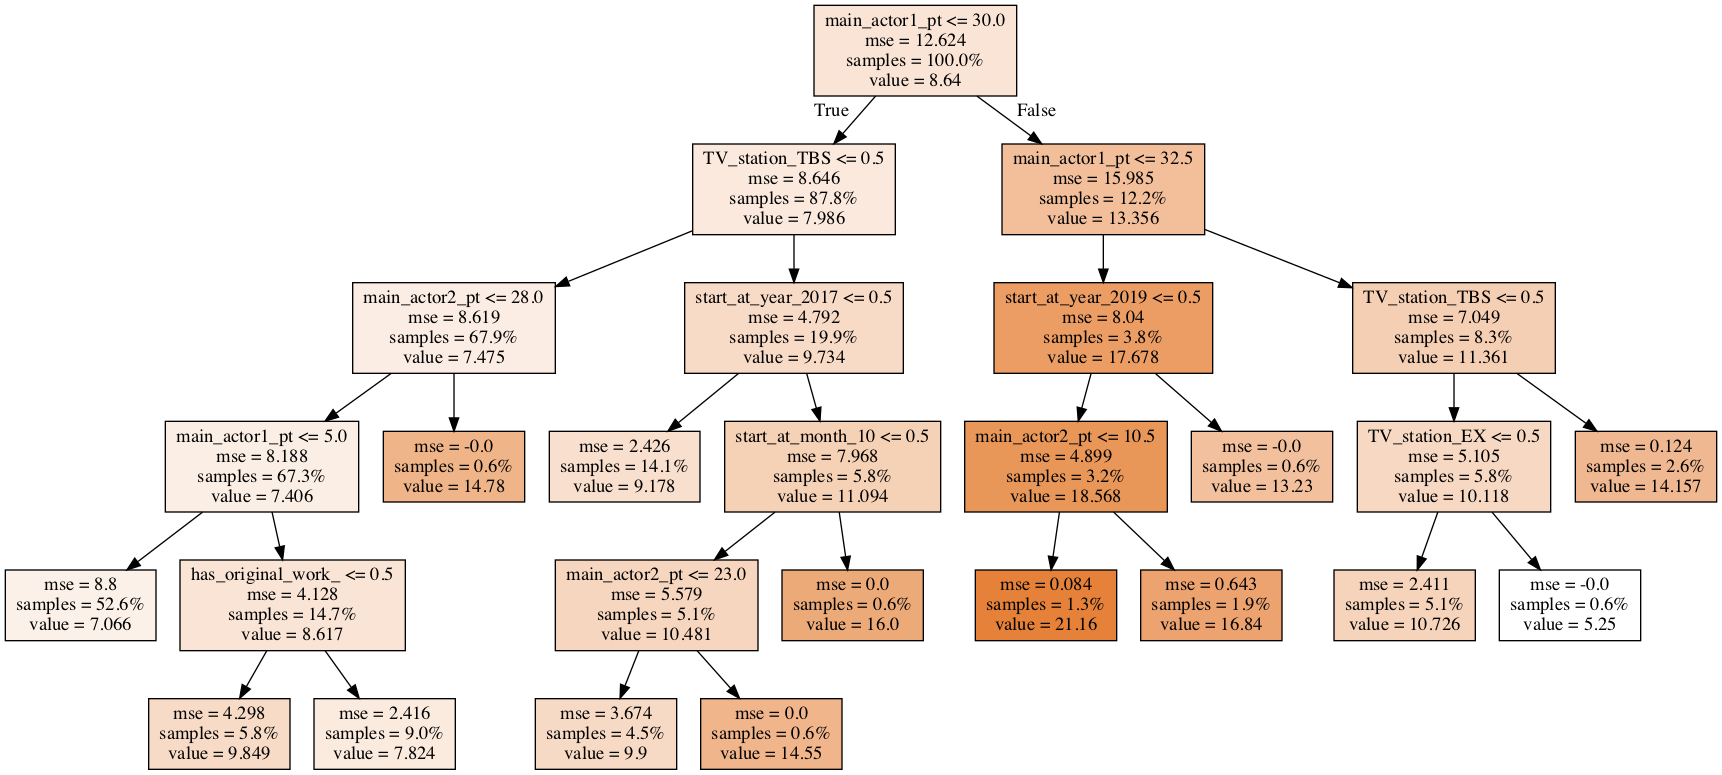

In [72]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())